In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, auc, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import geopandas as gpd
from shapely.geometry import LineString
import os
from sklearn.model_selection import train_test_split
import json


In [ ]:
import importlib
import functions
importlib.reload(functions)
from functions import features_change, build_train_test_val, features_engineering, change_dtype_cat



# Prepare data

In [4]:
# Load data
base_path = '/Users/stefa/OneDrive/Dokumente/Studies/Master/Semestre5/ML/Project2/ML_Projet_2'
full_path = os.path.join(base_path, 'data_y.npy')
data = np.load(full_path, allow_pickle=True)

In [5]:
# Deefine X and y array
X = data[:, :-1]
y = data[:, -1]

In [6]:
print(len(X))

9618522


In [7]:
df = pd.DataFrame(data, columns=['commune_1', 'commune_2', 'distance', 'year', 'pop_1', 'pop_2',
       'T_Mann', 'T_Frau', 'Etr_Total', 'Accidents dégâts matériels',
       'Accidents avec dommages corporels', 'Morts', 'GEM_FLAECH',
       'EINWOHNERZ', '0-25', '25-65', '65+', 'canton_code', 'unemployment',
       'gdp', 'T_Mann_2', 'T_Frau_2', 'Etr_Total_2',
       'Accidents dégâts matériels_2', 'Accidents avec dommages corporels_2',
       'Morts_2', 'GEM_FLAECH_2', 'EINWOHNERZ_2', '0-25_2', '25-65_2', '65+_2',
       'canton_code_2', 'unemployment_2', 'gdp_2', 'flow'])

In [8]:
df = features_engineering(df)

Column for multiplied population added
Column for population ratio added
Column for difference between gdp of the communes added
Column for distance between the communes squared added
Column for gravitation added


In [96]:
df.head()

,commune_1,commune_2,distance,year,pop_1,pop_2,T_Mann,T_Frau,Etr_Total,Accidents dégâts matériels,...,25-65_2,65+_2,canton_code_2,unemployment_2,gdp_2,flow,pop_1_x_pop_2,pop_1/pop_2_ratio,gdp_minus_gdp_2,gravity_raw
0,1.0,2.0,9.375965e+06,2018.0,1982.0,12229.0,982.0,1000.0,135.0,3.0,...,6981.0,2472.0,1.0,21793.250000,156883.07738,122.0,24237878.0,0.162074,0.0,2.757164e-07
1,1.0,2.0,9.375965e+06,2020.0,1982.0,12229.0,994.0,1020.0,143.0,7.0,...,7052.0,2551.0,1.0,26155.333333,149208.52863,79.0,24237878.0,0.162074,0.0,2.757164e-07
2,1.0,3.0,2.417420e+07,2018.0,1982.0,5548.0,982.0,1000.0,135.0,3.0,...,3151.0,997.0,1.0,21793.250000,156883.07738,10.0,10996136.0,0.357246,0.0,1.881637e-08
3,1.0,3.0,2.417420e+07,2020.0,1982.0,5548.0,994.0,1020.0,143.0,7.0,...,3107.0,1050.0,1.0,26155.333333,149208.52863,29.0,10996136.0,0.357246,0.0,1.881637e-08
4,1.0,4.0,2.451550e+07,2018.0,1982.0,3701.0,982.0,1000.0,135.0,3.0,...,2072.0,739.0,1.0,21793.250000,156883.07738,17.0,7335382.0,0.535531,0.0,1.220510e-08


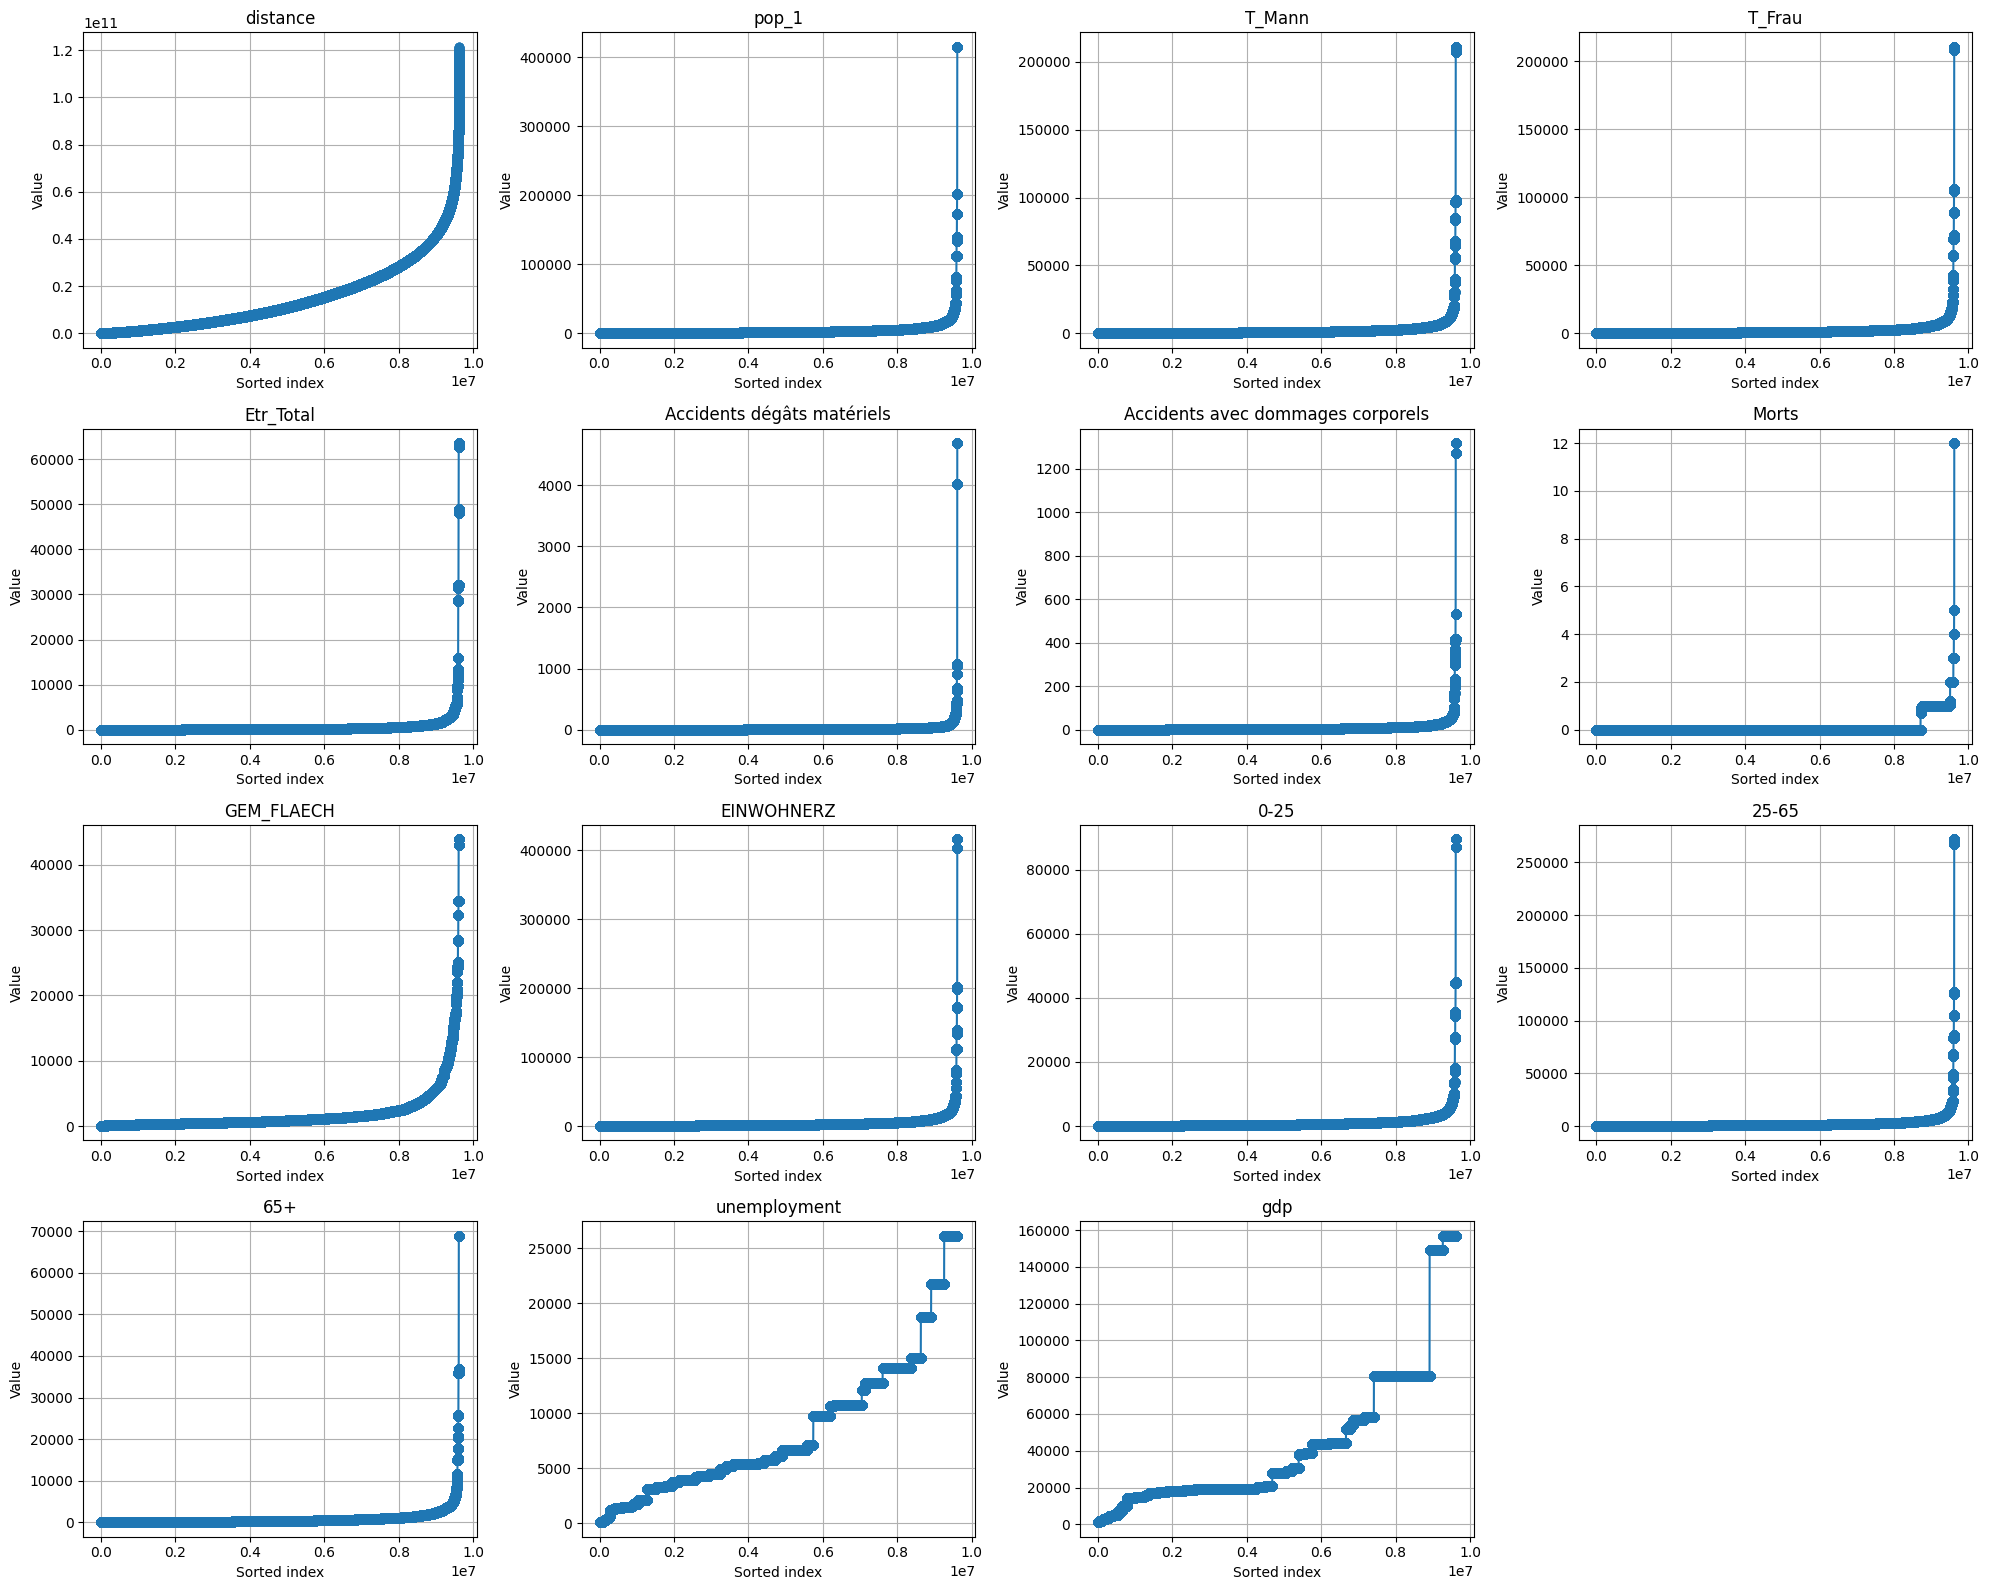

In [97]:
# Plot to see what features to transform to log
# List of columns to plot
cols_to_plot = [
    'distance', 'pop_1', 'T_Mann', 'T_Frau',
    'Etr_Total', 'Accidents dégâts matériels',
    'Accidents avec dommages corporels', 'Morts', 'GEM_FLAECH',
    'EINWOHNERZ', '0-25', '25-65', '65+', 'unemployment',
    'gdp',
]

# Determine number of subplots
n_cols = 4 
n_rows = int(np.ceil(len(cols_to_plot) / n_cols))

# Create figure
plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(cols_to_plot, 1):
    data_sorted = np.sort(df[col])
    
    plt.subplot(n_rows, n_cols, i)
    plt.plot(data_sorted, marker='o', linestyle='-')
    plt.title(col)
    plt.xlabel("Sorted index")
    plt.ylabel("Value")
    plt.grid(True)

plt.tight_layout()
plt.show()

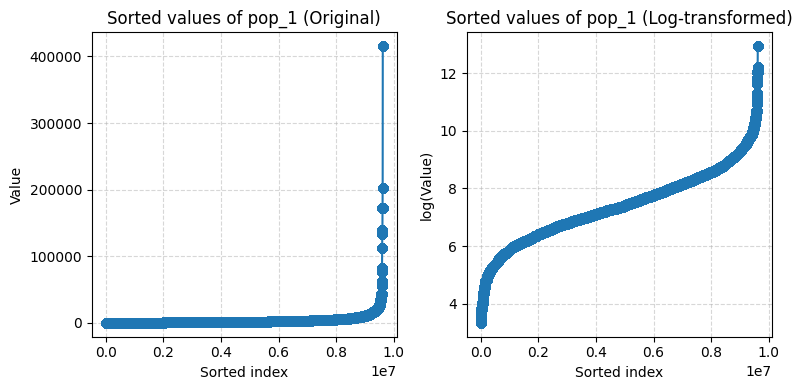

In [98]:
# Figure example for the benefits of log transformation

# Example column
col = 'pop_1'

# Drop NaNs and sort
data_sorted = np.sort(df[col].dropna())

# Log-transform
data_log = np.log(data_sorted)

# Reverse log - back to initial data
data_exp = np.exp(data_log)

# Plot side-by-side
plt.figure(figsize=(8,4))

# Original
plt.subplot(1, 2, 1)
plt.plot(data_sorted, marker='o', linestyle='-')
plt.title(f'Sorted values of {col} (Original)')
plt.xlabel('Sorted index')
plt.ylabel('Value')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Log-transformed
plt.subplot(1, 2, 2)
plt.plot(data_log, marker='o', linestyle='-')
plt.title(f'Sorted values of {col} (Log-transformed)')
plt.xlabel('Sorted index')
plt.ylabel('log(Value)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [99]:
# Transform to log the selected columns
not_log_transform = ['commune_1', 'commune_2', 'Morts','Morts_2', 'year', 'canton_code', 'unemployment','gdp','canton_code_2', 'unemployment_2', 'gdp_2', 'flow']
to_log = [col for col in df.columns if col not in not_log_transform]

df = features_change(df, to_log, "log")

c:\Users\stefa\anaconda3\envs\ML_project\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\stefa\AppData\Local\Temp\ipykernel_20076\1416344677.py:7: RuntimeWarning: divide by zero encountered in log
  y_non_null = np.log(y_data[~np.isnan(y_data)])
C:\Users\stefa\AppData\Local\Temp\ipykernel_20076\1416344677.py:11: RuntimeWarning: invalid value encountered in log
  y_log = np.log(y_non_null + 1e-5)


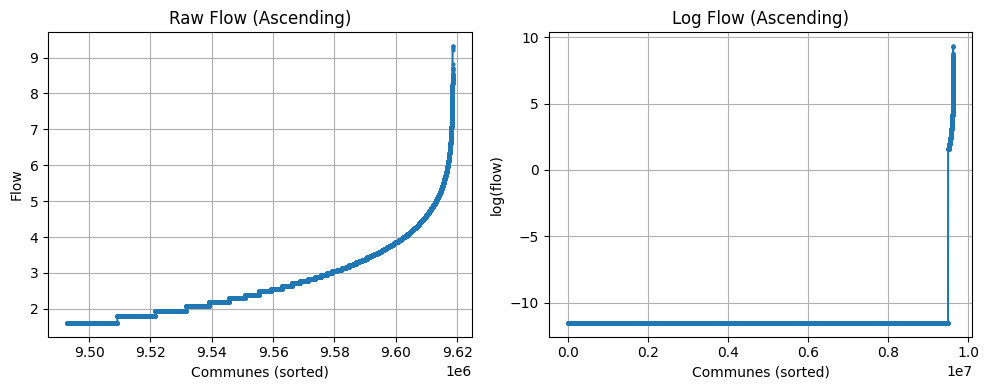

In [100]:
# Analyze y data

# Load y data
y_data = np.array(y)

# Remove NaNs
y_non_null = np.log(y_data[~np.isnan(y_data)])
y_null = np.log(y_data+1e-5)

# Log-transform (with epsilon to handle zeros)
y_log = np.log(y_non_null + 1e-5)

# Sort
y_sorted_raw = np.sort(y_non_null)
y_sorted_log = np.sort(y_null)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False)

# --- Raw flow ---
axes[0].plot(y_sorted_raw, marker='o', linestyle='-', markersize=2)
axes[0].set_title('Raw Flow (Ascending)')
axes[0].set_xlabel('Communes (sorted)')
axes[0].set_ylabel('Flow')
axes[0].grid(True)

# --- Log flow ---
axes[1].plot(y_sorted_log, marker='o', linestyle='-', markersize=2)
axes[1].set_title('Log Flow (Ascending)')
axes[1].set_xlabel('Communes (sorted)')
axes[1].set_ylabel('log(flow)')
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Catboosting

## Predict - Classification

### Preparation of dataset

In [9]:
# Define columns to remove, load data
to_remove_col = ['BFS_NUMMER','BFS_NUMMER_2',  'flow']

X_train, y_train, X_val, y_val, X_test, y_test =  build_train_test_val(df, test_canton_ids=[3], val_canton_ids=[19], zero_drop_ratio=0.2, random_state=37, features= to_remove_col, classify = True)

Splitting with canton [3] as test set:
Total flows: 9,618,522
Train size: 8,912,666 rows (92.7%)
Test size: 705,856 rows (7.3%)
Splitting with canton [19] as test set:
Total flows: 8,912,666
Train size: 7,227,626 rows (81.1%)
Test size: 1,685,040 rows (18.9%)
Dropping 20% of zeros in training data
Flow reclassified as 1: flow present, 0: no flow
Flow reclassified as 1: flow present, 0: no flow
Flow reclassified as 1: flow present, 0: no flow


In [10]:
X_train.head()

,commune_1,commune_2,distance,pop_1,pop_2,T_Mann,T_Frau,Etr_Total,Accidents dégâts matériels,Accidents avec dommages corporels,...,65+_2,canton_code_2,unemployment_2,gdp_2,pop_1_x_pop_2,pop_1/pop_2_ratio,gdp_minus_gdp_2,gravity_raw,year_2018.0,year_2020.0
0,553.0,6623.0,1.853836e+10,103.0,12167.0,47.0,56.0,6.0,3.0,1.0,...,2122.0,25.0,12154.583333,52015.88663,1253201.0,0.008466,28573.28112,3.646517e-15,0,1
1,57.0,2134.0,2.529728e+10,2371.0,844.0,1217.0,1154.0,132.0,5.0,4.0,...,138.0,10.0,4455.250000,19066.30713,2001124.0,2.809242,137816.77025,3.126988e-15,1,0
2,3255.0,338.0,1.897464e+10,4494.0,1480.0,2353.0,2287.0,689.0,6.0,2.0,...,374.0,2.0,14134.750000,80589.16775,6651120.0,3.036486,-41988.50838,1.847343e-14,0,1
3,6152.0,691.0,1.418578e+10,9256.0,509.0,4767.0,4831.0,1141.0,12.0,5.0,...,152.0,2.0,14134.750000,80589.16775,4711304.0,18.184675,-24146.47586,2.341180e-14,0,1
4,5458.0,5889.0,2.723132e+09,904.0,11828.0,425.0,454.0,77.0,0.0,5.0,...,2771.0,22.0,6658.166667,19025.75615,10692512.0,0.076429,0.00000,1.441924e-12,0,1


In [11]:
# Check that binary
print(y_train.unique())

[0 1]


In [12]:
# Define categorical features
cat_features = ['commune_1', 'commune_2','canton_code','canton_code_2', 'year_2018.0', 'year_2020.0']
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]

print(cat_feature_indexes)

[0, 1, 16, 30, 37, 38]


In [ ]:
'''def change_dtype_cat(cat_features, dataframe):
    for idx in cat_features:
        col = dataframe.columns[idx]
        dataframe[col] = dataframe[col].astype(str)
    return dataframe'''


In [13]:
# Change data types for categorical features
X_train2 = change_dtype_cat(cat_feature_indexes, X_train)
X_val2 =change_dtype_cat(cat_feature_indexes, X_val)
X_test2 = change_dtype_cat(cat_feature_indexes, X_test)

In [14]:
# Create CatBoost Pools
train_pool = Pool(data=X_train2, label=y_train, cat_features=cat_feature_indexes)
val_pool = Pool(data=X_val2, label=y_val, cat_features=cat_feature_indexes)
test_pool  = Pool(data=X_test2,  label=y_test, cat_features=cat_feature_indexes)

In [15]:
len(X_train2)

5801137

In [16]:
# Reduce datasize for grid search
X_tune, _, y_tune, _ = train_test_split(
    X_train2,
    y_train,
    train_size=0.5,
    stratify=y_train,
    random_state=37
)

print("Tuning set shape:", X_tune.shape)
print("Positive ratio (tune):", y_tune.mean())
print("Positive ratio (train):", y_train.mean())

Tuning set shape: (2900568, 39)
Positive ratio (tune): 0.016407476052966177
Positive ratio (train): 0.016407473224645443


### Grid search

In [ ]:
# Define model for grid search
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    cat_features=cat_feature_indexes,
    iterations=500,
    verbose=100
)

grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'class_weights': [[1,5], [1, 20], [1,50]]
}

grid_result = model.grid_search(
    grid,
    X=X_tune,
    y=y_tune,
    cv=3,
    stratified=True,
    shuffle=True,
    plot=False
)


0:	learn: 0.8134836	test: 0.8127893	best: 0.8127893 (0)	total: 576ms	remaining: 4m 47s
100:	learn: 0.8734184	test: 0.8770467	best: 0.8770467 (100)	total: 47.1s	remaining: 3m 6s
200:	learn: 0.8852823	test: 0.8921275	best: 0.8921275 (200)	total: 1m 39s	remaining: 2m 27s
300:	learn: 0.8904538	test: 0.8979747	best: 0.8979747 (300)	total: 2m 34s	remaining: 1m 42s
400:	learn: 0.8933945	test: 0.9003791	best: 0.9004574 (399)	total: 3m 29s	remaining: 51.8s
499:	learn: 0.8953240	test: 0.9030469	best: 0.9030469 (499)	total: 4m 31s	remaining: 0us

bestTest = 0.9030468568
bestIteration = 499

0:	loss: 0.9030469	best: 0.9030469 (0)	total: 4m 32s	remaining: 1h 58m 1s
0:	learn: 0.8134836	test: 0.8127893	best: 0.8127893 (0)	total: 661ms	remaining: 5m 30s
100:	learn: 0.8832171	test: 0.8889778	best: 0.8889778 (100)	total: 57.6s	remaining: 3m 47s
200:	learn: 0.8924086	test: 0.8991645	best: 0.8991645 (200)	total: 2m 1s	remaining: 3m
300:	learn: 0.8954927	test: 0.9031903	best: 0.9033056 (297)	total: 3m 5s	r

In [ ]:
# Print the best parameters
print("Best parameters:")
print(grid_result['params'])


Best parameters:
{'depth': 8, 'class_weights': [1, 5], 'learning_rate': 0.1}


In [ ]:
# Save them
best_params = model.get_params()

with open("catboost_best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)


### Model

In [34]:
# Load best parameters
with open("catboost_best_params.json", "r") as f:
    best_params = json.load(f)

final_model = CatBoostClassifier(
    **best_params,         
)


In [35]:
# Fit the model with the best parameter
final_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    early_stopping_rounds=50
)


0:	learn: 0.8313383	test: 0.7950753	best: 0.7950753 (0)	total: 27.2s	remaining: 3h 46m 25s
100:	learn: 0.9174261	test: 0.8358204	best: 0.8435642 (53)	total: 28m 40s	remaining: 1h 53m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8435642054
bestIteration = 53

Shrink model to first 54 iterations.


In [22]:
final_model.save_model("catboost_final_model3.cbm")

### Predict

In [ ]:
'''loaded_model = CatBoostClassifier() 
loaded_model.load_model("catboost_final_model3.cbm")
y_pred_proba = loaded_model.predict_proba(test_pool)[:, 1]
'''

In [46]:
y_pred_proba = final_model.predict_proba(test_pool)[:, 1]

In [47]:

# Iterate over threshold
thresholds = np.arange(0.4, 0.9, 0.01)
best_thresh = None
best_f1 = 0
y_pred_final = None

for thers in thresholds:
    y_pred_adjusted = (y_pred_proba > thers).astype(int)

    f1 = f1_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    acc = accuracy_score(y_test, y_pred_adjusted)

    if f1 > best_f1:
        best_thresh = thers
        best_f1 = f1
        y_pred_final = y_pred_adjusted


y_pred_adjusted = (y_pred_proba > best_thresh).astype(int)

In [48]:
print(best_f1)
print(best_thresh)

0.6967002568662319
0.6600000000000003


In [49]:

acc = accuracy_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
auc_param = roc_auc_score(y_test, y_pred_adjusted)
prec = precision_score(y_test, y_pred_adjusted)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc_param:.4f}")
print(f"Precision: {prec:.4f}")

Accuracy: 0.9913
F1 Score: 0.6967
Recall: 0.7036
AUC: 0.8495
Precision: 0.6900


In [50]:
# Assuming df_test contains the same order as y_test
df_test = X_test.copy()

# Correct predictions
df_test['correct'] = (y_test == y_pred_adjusted)

# Misclassified
df_test['misclassified'] = ~df_test['correct']

# Optional: classify type of error
df_test['error_type'] = np.where(
    (y_test == 1) & (y_pred_adjusted == 0), 'FN',  # missed flow
    np.where((y_test == 0) & (y_pred_adjusted == 1), 'FP', 'TP')
)


In [51]:
print("Unique values in 'correct':")
print(df_test['correct'].unique())

print("\nUnique values in 'misclassified':")
print(df_test['misclassified'].unique())

print("\nUnique values in 'error_type':")
print(df_test['error_type'].unique())


Unique values in 'correct':
[ True False]

Unique values in 'misclassified':
[False  True]

Unique values in 'error_type':
['TP' 'FN' 'FP']


### Plot map

In [273]:
flows = pd.read_pickle("flows.pkl")
communes = pd.read_pickle("communes.pkl")


In [274]:
X_test['year'] = X_test.apply(lambda row: 
                      2018 if row['year_2018.0'] == '1' else 
                      2020 if row['year_2020.0'] == '1' else None,
                      axis=1)
X_test.head()

,commune_1,commune_2,distance,pop_1,pop_2,T_Mann,T_Frau,Etr_Total,Accidents dégâts matériels,Accidents avec dommages corporels,...,canton_code_2,unemployment_2,gdp_2,pop_1_x_pop_2,pop_1/pop_2_ratio,gdp_minus_gdp_2,gravity_raw,year_2018.0,year_2020.0,year
1003,1,1001,1.966576e+09,1982.0,782.0,982.0,1000.0,135.0,3.0,2.0,...,3.0,3983.250000,27792.86656,1549924.0,2.534527,129090.21082,4.007642e-13,1,0,2018
1004,1,1001,1.966576e+09,1982.0,782.0,994.0,1020.0,143.0,7.0,5.0,...,3.0,5198.333333,28039.73666,1549924.0,2.534527,121168.79197,4.007642e-13,0,1,2020
1005,1,1002,1.946493e+09,1982.0,3284.0,982.0,1000.0,135.0,3.0,2.0,...,3.0,3983.250000,27792.86656,6508888.0,0.603532,129090.21082,1.717913e-12,1,0,2018
1006,1,1002,1.946493e+09,1982.0,3284.0,994.0,1020.0,143.0,7.0,5.0,...,3.0,5198.333333,28039.73666,6508888.0,0.603532,121168.79197,1.717913e-12,0,1,2020
1007,1,1004,3.577527e+09,1982.0,1961.0,982.0,1000.0,135.0,3.0,2.0,...,3.0,3983.250000,27792.86656,3886702.0,1.010709,129090.21082,3.036795e-13,1,0,2018


In [275]:
X_test[['commune_1', 'commune_2']] = X_test[['commune_1', 'commune_2']].astype(float).astype(int)

In [276]:
df_subset = flows.merge(
    X_test[['commune_1', 'commune_2', 'year']],
    on=['commune_1', 'commune_2', 'year'],
    how='right'
)


In [277]:
df_subset['y_true'] = y_test.values
df_subset['y_pred'] = y_pred_adjusted

In [278]:

# 2. Define prediction type for coloring
def prediction_type(row):
    if row['y_true'] == 1 and row['y_pred'] == 1:
        return 'correct'        # True Positive
    elif row['y_true'] == 0 and row['y_pred'] == 1:
        return 'FP'             # False Positive
    elif row['y_true'] == 1 and row['y_pred'] == 0:
        return 'FN'             # False Negative
    else:
        return 'TN'             # True Negative 

df_subset['prediction_type'] = df_subset.apply(prediction_type, axis=1)

# 3. Keep only flows that are present in true or predicted (skip TN)
flows_to_plot = df_subset[df_subset['prediction_type'] != 'TN'].copy()


In [279]:
# Add the geometry for the FN
centroid_map = communes.set_index('GEO_COMM')['centroid']
flows_to_plot['origin'] = flows_to_plot['origin'].fillna(
    flows_to_plot['commune_1'].map(centroid_map)
)

flows_to_plot['destination'] = flows_to_plot['destination'].fillna(
    flows_to_plot['commune_2'].map(centroid_map)
)


In [280]:
# Drop rows with missing coordinates
flows_to_plot_clean = flows_to_plot.dropna(subset=['origin', 'destination']).copy()

# Create LineString geometry
flows_to_plot_clean['geometry'] = flows_to_plot_clean.apply(
    lambda row: LineString([row['origin'], row['destination']]),
    axis=1
)


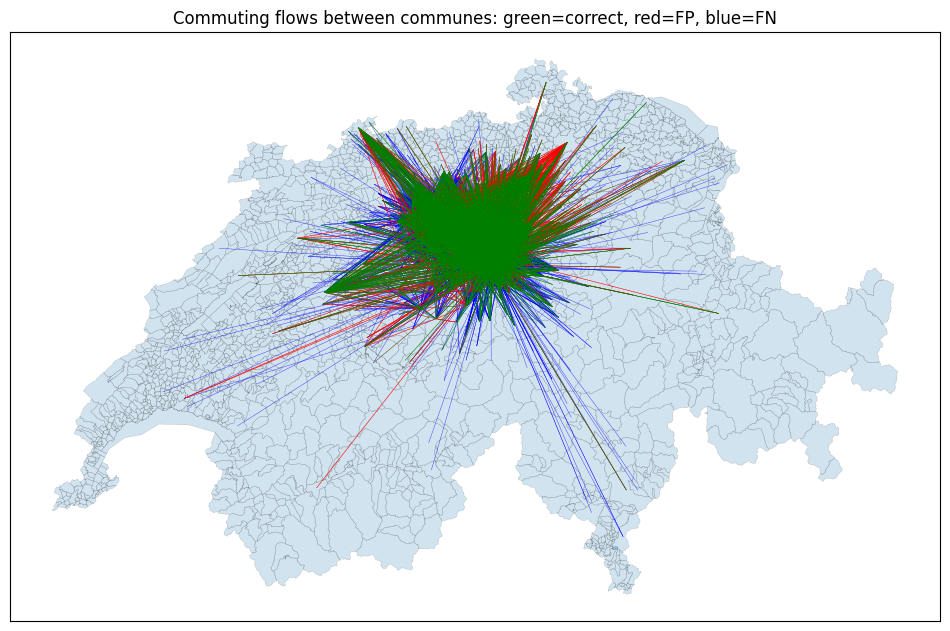

In [281]:
# To geodataframe
flow_gdf = gpd.GeoDataFrame(flows_to_plot_clean, geometry="geometry", crs=communes.crs)

# Plot map
fig, ax = plt.subplots(figsize=(12, 12))

communes.plot(ax=ax, linewidth=0.3, edgecolor="black", alpha=0.2)

color_map = {
    'correct': 'green',  # TP
    'FP': 'red',         # predicted flow but none
    'FN': 'blue'         # missed flow
}

for pred_type, group in flow_gdf.groupby('prediction_type'):
    group.plot(ax=ax, linewidth=0.3, color=color_map[pred_type], alpha=0.8)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.title("Commuting flows between communes: green=correct, red=FP, blue=FN")
plt.show()

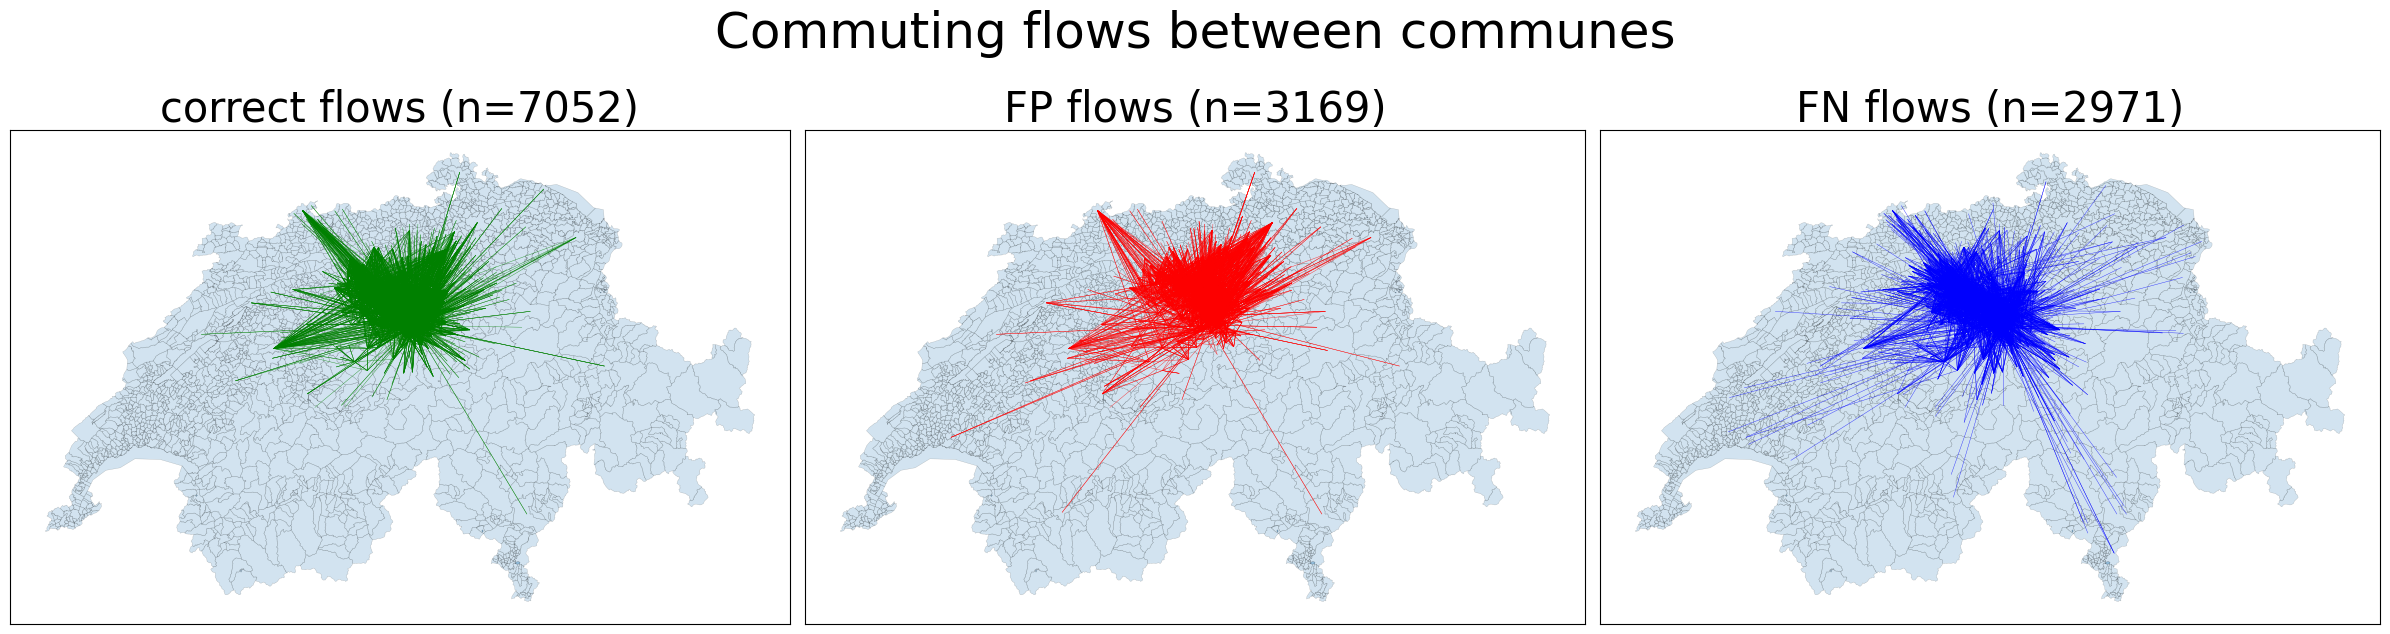

In [282]:
# Define prediction types and colors
pred_types = ['correct', 'FP', 'FN']
color_map = {
    'correct': 'green',
    'FP': 'red',
    'FN': 'blue'
}
counts = flow_gdf['prediction_type'].value_counts()

# Create figure 
fig, axes = plt.subplots(1, 3, figsize=(24, 7))  

for ax, pred_type in zip(axes, pred_types):
    communes.plot(ax=ax, linewidth=0.3, edgecolor="black", alpha=0.2)
    
    subset = flow_gdf[flow_gdf['prediction_type'] == pred_type]
    if not subset.empty:
        subset.plot(
            ax=ax,
            linewidth=0.3,
            color=color_map[pred_type],
            alpha=0.8
        )
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    count = counts.get(pred_type, 0)
    ax.set_title(f"{pred_type} flows (n={count})", fontsize=30)

plt.suptitle("Commuting flows between communes", fontsize=36)
plt.tight_layout()
plt.show()


### Plot - Evaluations

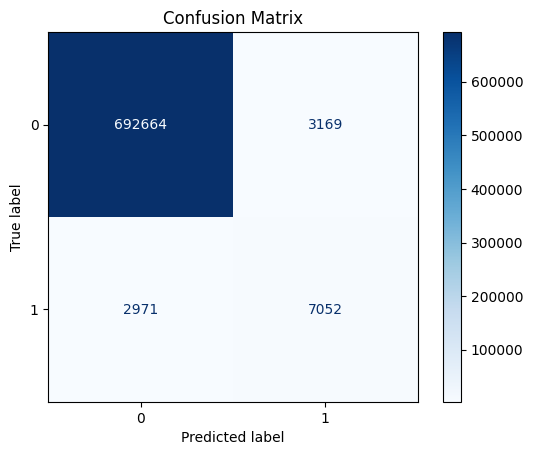

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

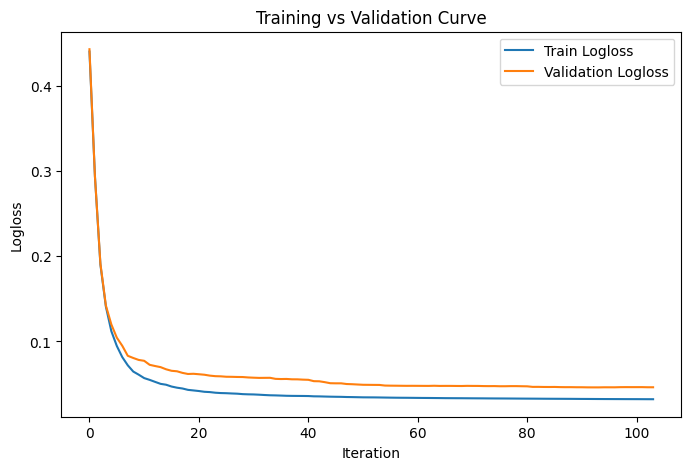

In [272]:
# Plot training vs validation curve`
evals_result = final_model.get_evals_result()

train_metric = evals_result['learn']['Logloss']
val_metric   = evals_result['validation']['Logloss']

plt.figure(figsize=(8,5))
plt.plot(train_metric, label='Train Logloss')
plt.plot(val_metric, label='Validation Logloss')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('Training vs Validation Curve')
plt.legend()
plt.show()

Precision-Recall AUC: 0.7715


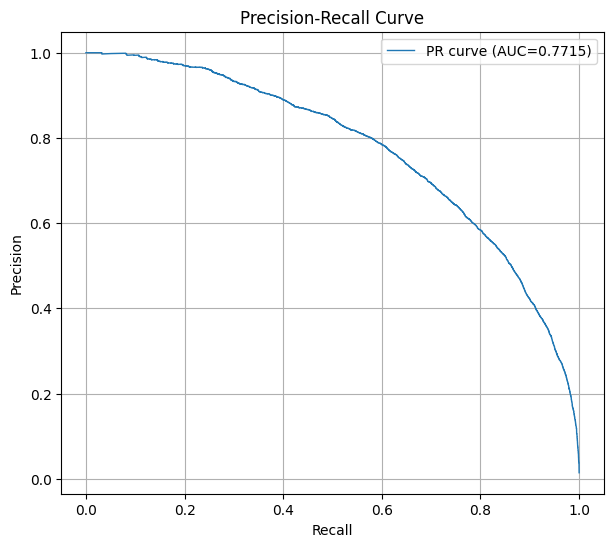

In [ ]:
# Plot precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Plot Precision-Recall curve
plt.figure(figsize=(7,6))
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.4f})', linewidth=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


## Predict - Regression

### Prepare data

In [321]:
to_remove_col = ['BFS_NUMMER','BFS_NUMMER_2',  'flow']
cat_features = ['commune_1', 'commune_2','canton_code','canton_code_2']

X_train, y_train, X_val, y_val, X_test, y_test =  build_train_test_val(df, test_canton_ids=[3], val_canton_ids=[19], zero_drop_ratio=0, random_state=37, features= to_remove_col, classify = False)

Splitting with canton [3] as test set:
Total flows: 125,559
Train size: 115,536 rows (92.0%)
Test size: 10,023 rows (8.0%)
Splitting with canton [19] as test set:
Total flows: 115,536
Train size: 95,182 rows (82.4%)
Test size: 20,354 rows (17.6%)
Dropping 0% of zeros in training data


In [322]:
# Treat categorical features
cat_features = ['commune_1', 'commune_2','canton_code','canton_code_2', 'year_2018.0', 'year_2020.0']
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]

print(cat_feature_indexes)

[0, 1, 16, 30, 37, 38]


In [324]:
# Prepare final datasets
X_train2 = change_dtype_cat(cat_feature_indexes, X_train)
X_val2 =change_dtype_cat(cat_feature_indexes, X_val)
X_test2 = change_dtype_cat(cat_feature_indexes, X_test)

In [325]:
# Logtransform the datasets of evaluation
y_train = np.log(y_train)
y_val = np.log(y_val)
#y_test = np.log(y_test)

In [326]:
# Create CatBoost Pools (same as before)
train_pool = Pool(data=X_train2, label=y_train, cat_features=cat_feature_indexes)
val_pool = Pool(data=X_val2, label=y_val, cat_features=cat_feature_indexes)
test_pool  = Pool(data=X_test2,  label=y_test, cat_features=cat_feature_indexes)

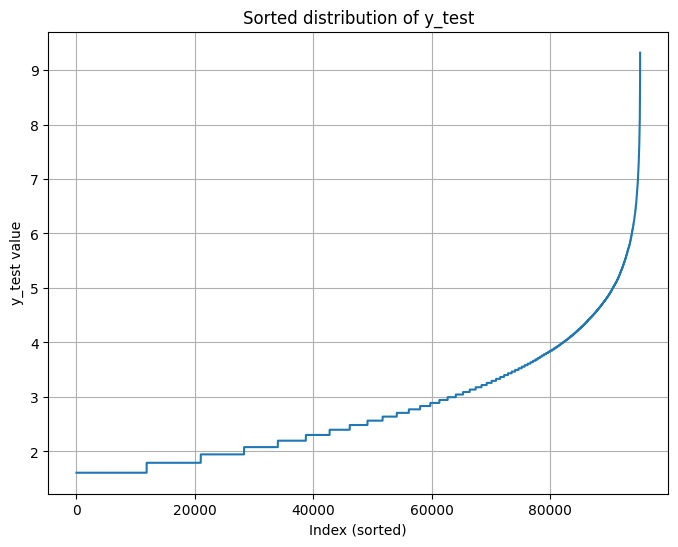

In [327]:
# Sort y_test values
y_sorted = np.sort(y_train)

# Plot sorted values against index
plt.figure(figsize=(8, 6))
plt.plot(y_sorted)
plt.xlabel("Index (sorted)")
plt.ylabel("y_test value")
plt.title("Sorted distribution of y_test")
plt.grid(True)
plt.show()


### Grid search

In [328]:
cat_model = CatBoostRegressor(
    random_state=42,
    verbose=0
)

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.7,  0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
}

grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='r2',      # or 'neg_mean_squared_error', etc.
    cv=3,              # 3-fold cross-validation
    n_jobs=-1          # use all CPU cores
)

In [21]:
grid_search.fit(X_train, y_train)

,estimator,<catboost.cor...t 0x158a9a270>
,param_grid,"{'depth': [4, 6, ...], 'l2_leaf_reg': [1, 3, ...], 'learning_rate': [0.01, 0.03, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [28]:
grid_search.best_params_
    

{'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

### Model

In [330]:
# Model with found parameters in grid search
model = CatBoostRegressor(
    iterations=500,          
    depth=8,                
    learning_rate=0.1,  
    l2_leaf_reg= 1,   
    loss_function='RMSE',  
    eval_metric='R2',    
    random_seed=42,
    task_type='CPU',
    verbose=50
)


In [331]:
# Fit model
model.fit(
    train_pool,
    eval_set=val_pool,       # optional validation set
    use_best_model=True,     # stop at best iteration
    early_stopping_rounds=100
)

0:	learn: 0.0957466	test: 0.0467013	best: 0.0467013 (0)	total: 221ms	remaining: 1m 50s
50:	learn: 0.7632811	test: 0.3815002	best: 0.5638069 (26)	total: 16.6s	remaining: 2m 26s
100:	learn: 0.7925458	test: 0.3363276	best: 0.5638069 (26)	total: 51.9s	remaining: 3m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5638068969
bestIteration = 26

Shrink model to first 27 iterations.


In [333]:
# Predict on the original data
y_pred_log = model.predict(X_test2)
y_pred = np.expm1(y_pred_log)

# Evaluation of model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 99.5347
MAE: 19.0498
R²: 0.3383


### Plot

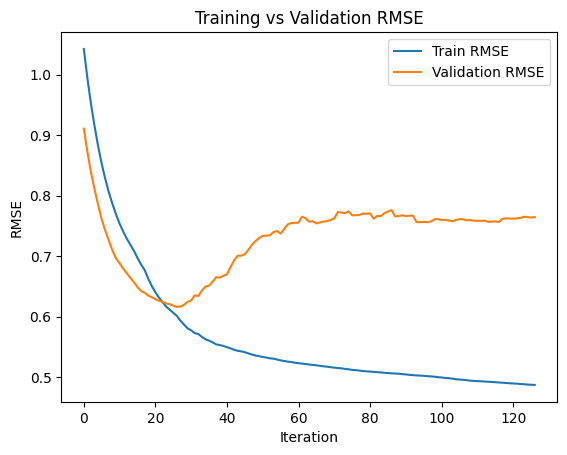

In [334]:
# Assuming model has been trained with eval_set
train_rmse = model.get_evals_result()['learn']['RMSE']
valid_rmse = model.get_evals_result()['validation']['RMSE']

plt.plot(train_rmse, label='Train RMSE')
plt.plot(valid_rmse, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.show()
